

## Experiment Details
__Experiment Id__ : 009 \
__Target__ : test model on alphanumeric sticker dataset \
__Solution__ : 
- build a dataset from [Standard-OCR](https://www.kaggle.com/datasets/preatcher/standard-ocr-dataset?resource=download) dataset 
- test the model performance on the new dataset

__Empirical result__ : 
- model shows very high accuracy in both training and validation phases
- model prediction is clear
- __the dataset represents all alphanumeric latters, mean 36 classes and still model keep-up best performance__ : _model performance independent from the number of target classes_
- __the dataset contains different font styles, font size and intensity level per each latter__ : _having good performance mean the model immune to those changes ans model could successfully extract the latter_
- __In the dataset stickers inter-latter space changes radically and randomly__ : _but model region identification layers still able to light correct regions and give correct output_

---
Implementation

In [24]:
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import losses

from tqdm import tqdm
import math
import os
import time
import random 
import pandas as pd 
import numpy as np
from skimage import io, transform 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
from bidict import bidict
from glob import glob 

import neptune.new as neptune

---
Set global variables

In [2]:
gpu_available = tf.config.list_physical_devices('GPU')
gpu_available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
IMAGE_SIZE = (128,48)
DATA_BS = 10
DATA_N = 10
LR = 0.005
EPOCHS = 10
BS = 32


---
Dataset & Dataloader 

In [4]:
class StandardOCRDataset(object):

    def __init__(self, data_path, n_digits=8, image_size=(156, 32)):
        self._path = data_path
        self.n_digits = n_digits
        self.image_size = image_size

    def load_img(self, path):
        im_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        rz_path = cv2.resize(im_gray, (28, 28), interpolation=cv2.INTER_AREA)
        return rz_path

    def load_data(self, data_path, training=True):
        if training:
            data_path = data_path+'/training_data'
        else:
            data_path = data_path+'/testing_data'

        data = []
        label = []
        for d in glob(f'{data_path}/*/'):
            d = d.replace(os.sep, '/')
            c = d.split('/')[-2]
            for f in glob(f'{d}/*.png'):
                f = f.replace(os.sep, '/')
                img = self.load_img(f)
                data.append(img)
                label.append(c)
            
        return np.array(data), np.array(label)

    def gen_patch(self, img, ann, c=np.inf):
        size = img.shape[0]
        indexes = np.arange(size)
        np.random.shuffle(indexes)
        
        c_prime = divmod(size, self.n_digits)[0]*self.n_digits
        if c_prime < c:
            size = c_prime
        else:
            size = divmod(c, self.n_digits)[0]*self.n_digits

        sample_index = indexes[:size]
        sticker_index = sample_index.reshape((-1, self.n_digits)).T
        sticker_images = np.transpose(np.hstack([np.transpose(img[inds], (0, 2, 1)) for inds in sticker_index]), (0, 2, 1))
        sfl_label =  ann[sample_index, ...]
        sticker_labels = sfl_label.reshape((-1, self.n_digits))
        return sticker_images, sticker_labels

    def generate(self, training=True, n_sample=1000):
        init_image, init_label = self.load_data(self._path, training)
        classes = list(np.unique(init_label))
        cl_dict = dict(zip(classes, range(len(classes))))
        cl_bidict = bidict(cl_dict)
        
        def func(x):
            return cl_bidict[x]

        vfunc = np.vectorize(func)
        init_label = vfunc(init_label)

        c = n_sample
        dt_images, dt_labels = self.gen_patch(init_image, init_label, c)
        while c > self.n_digits:
            c = n_sample - dt_images.shape[0]
            p_images, p_labels = self.gen_patch(init_image, init_label, c)
            dt_images, dt_labels = np.vstack((dt_images, p_images)), np.vstack((dt_labels, p_labels))

        ret_tensor = tf.convert_to_tensor(np.swapaxes(dt_images, 1, 2), dtype=tf.float32)
        ind_tensor = tf.convert_to_tensor(dt_labels, dtype=tf.int32)
        dataset = tf.data.Dataset.from_tensor_slices((ret_tensor, ind_tensor))
        return dataset, cl_bidict

In [5]:
datasetGen = StandardOCRDataset('../../datasets/SOCRN')

In [6]:
train_dataset, label_mapper = datasetGen.generate(training=True, n_sample=12000)
test_dataset, _ = datasetGen.generate(training=False, n_sample=2000)

(224, 28)
[31 30  2 18 26 33 12  4]


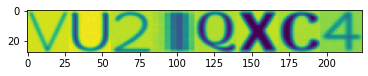

In [7]:
for i in test_dataset.take(1):
    img, label = i
    print(img.shape)
    print(label.numpy())
    plt.imshow(img.numpy().T)


IMAGE_SIZE = img.shape
MAX_OBJ = len(label)
N_CLASSES = len(label_mapper)


In [8]:
train_loader = train_dataset.shuffle(buffer_size=1000).batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_loader = test_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

---
Model Defining

In [9]:
class mAP(tf.keras.metrics.Metric):
    def __init__(self, name='mAP', alpha=0.9, **kwargs):
        super(mAP, self).__init__(name=name, **kwargs)
        self.map = self.add_weight(name='map', initializer='zeros')
        self.alpha = alpha

    def update_state(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        alpha = tf.constant(self.alpha, dtype=tf.float32)
        alpha_prime = tf.constant(1-self.alpha, dtype=tf.float32)

        res_arr = tf.map_fn(lambda i: tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(y_true[i, ...], y_pred[i, ...])), elems=tf.range(y_pred.shape[0]), dtype=tf.float32)
        tensor_without_nans = tf.where(tf.math.is_nan(res_arr), tf.zeros_like(res_arr), res_arr)
        cur_val = tf.math.reduce_mean(tensor_without_nans, axis=-1)
        weighted_avg = tf.math.add(tf.multiply(alpha, self.map), tf.multiply(alpha_prime, cur_val))
        self.map.assign(weighted_avg)

    def result(self):
        return self.map


In [10]:
class mDP(tf.keras.metrics.Metric):
    def __init__(self, name='mDP', n_classes=10, alpha=0.9, **kwargs):
        super(mDP, self).__init__(name=name, **kwargs)
        self.n = n_classes
        self.alpha = alpha
        self.mdp = self.add_weight(name='mdp', initializer='zeros')

    def update_state(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.cast(y_pred, tf.float32)
        alpha = tf.constant(self.alpha, dtype=tf.float32)
        alpha_prime = tf.constant(1-self.alpha, dtype=tf.float32)

        def func(i):
            mask = tf.equal(y_true, tf.constant(i))
            ilabels = tf.reshape(tf.boolean_mask(y_true,mask), shape=(-1))
            ipreds = tf.reshape(tf.boolean_mask(y_pred,mask), shape=(-1, self.n))
            return tf.math.reduce_mean(tf.keras.metrics.sparse_categorical_accuracy(ilabels, ipreds))

        res_arr = tf.map_fn(lambda i: func(i), elems=tf.range(self.n), dtype=tf.float32)
        tensor_without_nans = tf.where(tf.math.is_nan(res_arr), tf.zeros_like(res_arr), res_arr)
        cur_val = tf.math.reduce_mean(tensor_without_nans, axis=-1)
        weighted_avg = tf.math.add(tf.multiply(alpha, self.mdp), tf.multiply(alpha_prime, cur_val))
        self.mdp.assign(weighted_avg)

    def result(self):
        return self.mdp

In [11]:
class RecNet(tf.keras.Model):
	def __init__(self, bs=16, input_size=(128, 48), n_classes=10, h_cell=64, latent_size=32, max_obj=15, linear_k=3, rho=0.05):
		super().__init__()
		self.rho = rho
		self.bs = bs
		self.input_size = input_size
		self.n_classes = n_classes  # LSTM module projection size
		self.h_cell = h_cell  # LSTM hidden size
		self.latent_size = latent_size
		self.max_obj = max_obj
		self.linear_k = linear_k
		self.model = self.build_model(
			self.input_size, self.h_cell, self.latent_size, self.n_classes, self.max_obj, self.linear_k)

		self.scce = losses.SparseCategoricalCrossentropy(from_logits=False,)

		self.loss_metric = tf.keras.metrics.Mean(name="loss")
		self.acc_metric = tf.keras.metrics.Mean(name="accuracy")
		self.mAP = mAP()
		self.mDP = mDP(n_classes=self.n_classes)
		self.acc_mat = tf.keras.metrics.Accuracy()

	def build_model(self, input_shape=(128, 48), h_cell=32, latent_size=32, n_classes=10, n_obj=10, linear_k=3):
		x_input = layers.Input(shape=input_shape)
		forward_layer = layers.LSTM(h_cell//2, return_sequences=True)
		x = layers.Bidirectional(forward_layer, input_shape=self.input_size)(x_input)
		x = layers.LSTM(latent_size, activation='tanh',
						return_sequences=True, go_backwards=True)(x)
		x = layers.Conv1D(n_classes, linear_k, activation='tanh')(x)
		x = layers.Permute((2, 1))(x)
		x = layers.Conv1D(n_obj, 1, activation='tanh')(x)
		x = layers.Permute((2, 1))(x)
		x_output = layers.Activation('softmax')(x)

		model = tf.keras.Model(inputs=x_input, outputs=x_output)
		return model

	@property
	def metrics(self):
		return [self.loss_metric, self.acc_mat]

	def calculate_loss(self, target, pred):
		target = tf.reshape(target, shape=(-1))
		pred = tf.reshape(pred, shape=(-1, self.n_classes))
		loss = self.scce(target, pred)

		y_hat = tf.argmax(pred, axis=-1)
		acc = self.acc_mat(y_hat, target)
		return loss, acc

	def call(self, x):
		full_out = self.model(x)
		return full_out

	def train_step(self, batch_data):
		x, target = batch_data
		e_ws = []
		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			# print(pred.shape, pred)
			loss, acc = self.calculate_loss(target, pred)

		trainable_params = self.trainable_variables
		gradients = tape.gradient(loss, trainable_params)
		grad_norm = self._grad_norm(gradients)
		scale = self.rho / (grad_norm + 1e-12)

		for (grad, param) in zip(gradients, trainable_params):
			e_w = grad*scale 
			param.assign_add(e_w)
			e_ws.append(e_w)

		with tf.GradientTape() as tape:
			pred = self(x, training=True)
			loss, acc = self.calculate_loss(target, pred)

		sam_gradient = tape.gradient(loss, trainable_params)
		for (param, e_w) in zip(trainable_params, e_ws):
			param.assign_sub(e_w)

		self.optimizer.apply_gradients(zip(sam_gradient, trainable_params))
		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		self.mAP.update_state(target, pred)
		self.mDP.update_state(target, pred)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
			"mAP": self.mAP.result(),
			"mDP": self.mDP.result()
		}

	def test_step(self, batch_data):
		x, target = batch_data

		pred = self(x, training=False)
		loss, acc = self.calculate_loss(target, pred)

		self.loss_metric.update_state(loss)
		self.acc_metric.update_state(acc)
		self.mAP.update_state(target, pred)
		self.mDP.update_state(target, pred)
		return {
			"loss": self.loss_metric.result(),
			"accuracy": self.acc_mat.result(),
			"mAP": self.mAP.result(),
			"mDP": self.mDP.result()
		}

	def _grad_norm(self, gradients):
		norm = tf.norm(
			tf.stack([
				tf.norm(grad) for grad in gradients if grad is not None
			])
		)
		return norm


---
Set up model training details

In [14]:
def lr_time_based_decay(epoch, lr):
    decay = 0.001
    return lr * 1 / (1 + decay * epoch)

def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return LR * math.pow(drop_rate, math.floor(epoch/epochs_drop))

def lr_exp_decay(epoch, lr):
    k = 0.1
    return LR * math.exp(-k*epoch)

decay_steps = 500
# lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
#     LR, decay_steps)

lr_decaying_callback = tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)

In [15]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                            monitor='val_accuracy',
                            min_delta=0,
                            patience=5,
                            restore_best_weights=True
                        )

In [16]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
)

In [17]:
# model = RecNet(bs=BS)
model = RecNet(input_size=IMAGE_SIZE,
                bs=BS,
                n_classes=N_CLASSES,
                h_cell=32,
                max_obj=MAX_OBJ,
                linear_k=3)
model.compile(optimizer, loss='categorical_crossentropy', run_eagerly=True)

In [19]:
model.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 28)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 224, 32)          5760      
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 224, 32)           8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 222, 36)           3492      
                                                                 
 permute_2 (Permute)         (None, 36, 222)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 36, 8)             1784      
                                                           

In [20]:
model.fit(
    train_loader,
    epochs=20,
    validation_data=valid_loader,
    callbacks=[earlystopping_callback,
               lr_decaying_callback]
)


Epoch 00001: LearningRateScheduler setting learning rate to 0.005.
Epoch 1/20
374/374 [==============================] - 209s 528ms/step - loss: 2.3798 - accuracy: 0.6423 - mAP: 0.6063 - mDP: 0.6066 - val_loss: 1.8534 - val_accuracy: 0.9226 - val_mAP: 0.9163 - val_mDP: 0.9246 - lr: 0.0050

Epoch 00002: LearningRateScheduler setting learning rate to 0.005.
Epoch 2/20
374/374 [==============================] - 203s 544ms/step - loss: 1.9456 - accuracy: 0.8799 - mAP: 0.8710 - mDP: 0.8709 - val_loss: 1.8159 - val_accuracy: 0.9395 - val_mAP: 0.9337 - val_mDP: 0.9409 - lr: 0.0050

Epoch 00003: LearningRateScheduler setting learning rate to 0.005.
Epoch 3/20
374/374 [==============================] - 207s 554ms/step - loss: 1.9094 - accuracy: 0.8958 - mAP: 0.8902 - mDP: 0.8897 - val_loss: 1.8269 - val_accuracy: 0.9252 - val_mAP: 0.9192 - val_mDP: 0.9258 - lr: 0.0050

Epoch 00004: LearningRateScheduler setting learning rate to 0.005.
Epoch 4/20
374/374 [==============================] - 217s 

---
Model Prediction & Evaluation

In [21]:
# Generate test dataset 
test_dataset, _ = datasetGen.generate(training=False, n_sample=2000)
test_loader = test_dataset.batch(BS, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
def model_evaluator(model, dt_loader, n_classes):
    map_mat = mAP()
    mdp_mat = mDP(n_classes=n_classes)
    acc_mat = tf.keras.metrics.Accuracy()
    time_mat = []
    for bt in dt_loader:
        x, target = bt
        start_time = time.time()
        pred = model(x)
        end_time = time.time()
        time_mat.append((end_time-start_time)/BS)

        map_mat.update_state(target, pred)
        mdp_mat.update_state(target, pred)
        pred = tf.reshape(pred, shape=(-1, n_classes))
        y_hat = tf.argmax(pred, axis=-1)
        target = tf.reshape(target, shape=(-1))
        # print(y_hat.shape, pred.shape, target.shape)
        acc_mat.update_state(y_hat, target)
        break
    mean_time = sum(time_mat)/ len(time_mat)
    print({
        'Accuracy': acc_mat.result().numpy(),
        'mAP': map_mat.result().numpy(),
        'mDP': mdp_mat.result().numpy(),
        'mean_average_execution_time': mean_time
    })

In [26]:
model_evaluator(model, test_loader, N_CLASSES)

{'Accuracy': 0.95703125, 'mAP': 0.095703125, 'mDP': 0.097183146, 'mean_average_execution_time': 0.0008405819535255432}


---
* Individual prediction & labeling 

In [27]:
for s in test_dataset.take(10):
    test_image, test_label = s
     

test_class = test_label.numpy()


In [28]:
test_class

array([23, 34, 10, 28, 22, 27, 23,  7])

In [29]:
sample = tf.expand_dims(test_image, axis=0)
sample_output = model(sample)

In [30]:
sample_output.shape

TensorShape([1, 8, 36])

In [31]:
pred_classes = tf.argmax(sample_output[0], axis=1).numpy()
pred_labels = [label_mapper.inverse[i] for i in pred_classes]
print(pred_classes)
print(pred_labels)

[23 34 10 28 22 27 23  7]
['N', 'Y', 'A', 'S', 'M', 'R', 'N', '7']


In [33]:
label_mapper.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])

In [41]:
def pred_eval_plot(pred_heatmap, image, ylabels, figsize=(10, 15)):
    fig, axes = plt.subplots(2, 1, figsize=figsize,)
    sns.heatmap(ax=axes[0], data=pred_heatmap, linewidths=1, cbar=False, cmap='Blues', yticklabels=ylabels)
    axes[1].imshow(image, cmap='gray', aspect='equal')
    plt.show()

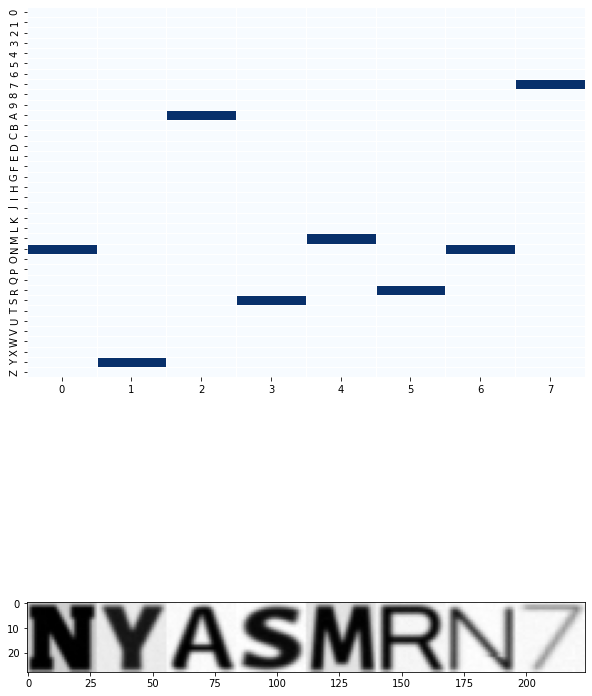

In [42]:
pred_eval_plot(sample_output[0, ...].numpy().T, test_image.numpy().T, list(label_mapper.keys()))

---